# Implementing a Recommender System with SageMaker, MXNet, and Gluon
_**신경망 및 임베딩을 사용하여 비디오 추천 만들기**_

--- 

---

이 노트북의 내용은 하위 내용들을 참조했습니다. 자세한 내용은 링크를 통해 확인할 수 있습니다.

*[Cyrus Vahid's 2017 re:Invent Talk](https://github.com/cyrusmvahid/gluontutorials/blob/master/recommendations/MLPMF.ipynb)

*[AWS Amazon SageMaker Examples](https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/gluon_recommender_system/gluon_recommender_system.ipynb)



## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
  1. [Explore](#Explore)
  1. [Clean](#Clean)
  1. [Prepare](#Prepare)
1. [Train Locally](#Train-Locally)
  1. [Define Network](#Define-Network)
  1. [Set Parameters](#Set-Parameters)
  1. [Execute](#Execute)
1. [Train with SageMaker](#Train-with-SageMaker)
  1. [Wrap Code](#Wrap-Code)
  1. [Move Data](#Move-Data)
  1. [Submit](#Submit)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
1. [Wrap-up](#Wrap-up)

---

## Background

여러 면에서 추천 시스템은 현재 기계 학습의 인기를 촉진하는 촉매제였습니다. 아마존의 초기 성공 중 하나는 “이 제품을 구매하고 구매 한 고객...” 기능이었으며, 백만 달러짜리 Netflix Prize 는 이 연구에 박차를 가하고 대중의 인식을 높이며 수많은 다른 데이터 과학 대회에 영감을 불어 넣었습니다.

추천자 시스템은 다양한 데이터 소스와 ML 알고리즘을 활용할 수 있으며, 대부분은 다양한 비지도, 지도 및 강화 학습 기술을 전체적인 프레임워크에 결합합니다. 그러나 핵심 구성 요소는 거의 항상 유사한 항목에 대한 사용자의 과거 평점과 다른 유사한 사용자의 행동을 기반으로 특정 항목에 대한 사용자의 평가 (또는 구매) 를 예측하는 모델입니다. 이에 필요한 최소 데이터셋은 사용자의 아이템 평가 기록입니다. 이 노트북 예제의 경우 160,000개 이상의 디지털 동영상에 2백만 명 이상의 아마존 고객의 별 1~5개 등급을 사용합니다. 이 데이터 세트에 대한 자세한 내용은 [AWS Public Datasets page](https://s3.amazonaws.com/amazon-reviews-pds/readme.html) 에서 확인할 수 있습니다.

행렬 분해 (Matrix factorization)는 대부분의 사용자 항목 예측 모델의 초석이었습니다. 이 메서드는 사용자가 행을 인덱싱하고 항목이 열을 인덱싱하는 사이즈가 크고, 스파스된 단일 행렬의 항목 등급으로 시작합니다. 그런 다음 곱했을때 더 큰 행렬의 정보와 관계를 유지하는 밀도가 낮은 두 개의 저차원 행렬을 찾습니다.

![image](https://developers.google.com/machine-learning/recommendation/images/Matrixfactor.svg)

행렬 분해는 딥 러닝 및 임베딩을 통해 확장되고 일반화되었습니다. 이러한 기술을 통해 향상된 성능과 유연성을 위해 비선형성을 도입할 수 있습니다. 이 노트북은 신경망 기반 모델에 적합하여 Amazon 비디오 데이터 세트에 대한 권장 모델을 생성합니다. 먼저 노트북에서 데이터를 탐색하고 데이터 샘플에 대한 모델을 학습하는 것으로 시작합니다. 나중에 전체 데이터세트로 확장하고 SageMaker 관리형 학습 클러스터를 사용하여 모델을 만들 것입니다. 그런 다음 엔드포인트에 배포하고 모델을 검증합니다.

---

## Setup

_이 노트북은 ml.p2.xlarge 노트북 인스턴스에서 생성 및 테스트되었습니다._

먼저 다음을 지정해 보도록 합니다.:

- 학습 및 모델 데이터에 사용할 S3 버킷 및 prefix 입니다. 이 인스턴스는 노트북 인스턴스, 학습 및 호스팅과 동일한 리전 내에 있어야 합니다.
- 데이터에 대한 교육 및 호스팅 액세스 권한을 부여하는데 IAM 역할 ARN 이 사용됩니다. 이러한 파일을 만드는 방법은 설명서를 참조하십시오. 노트북 인스턴스, 교육 및/또는 호스팅에 둘 이상의 역할이 필요한 경우 `get_execution_role ()` 호출을 적절한 전체 IAM 역할 ARN 문자열로 바꾸십시오.


In [1]:
import sagemaker
import boto3

role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix
bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/DEMO-gluon-recsys"

In [2]:
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE
import pandas as pd
import numpy as np
from sagemaker.mxnet import MXNet
import json
import matplotlib.pyplot as plt
import json

In [3]:
!mkdir /tmp/recsys/
!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz /tmp/recsys/

download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz to ../../../tmp/recsys/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz


In [4]:
df = pd.read_csv(
    "/tmp/recsys/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz",
    delimiter="\t",
    error_bad_lines=False,
)
df.head()

b'Skipping line 92523: expected 15 fields, saw 22\n'
b'Skipping line 343254: expected 15 fields, saw 22\n'
b'Skipping line 524626: expected 15 fields, saw 22\n'
b'Skipping line 623024: expected 15 fields, saw 22\n'
b'Skipping line 977412: expected 15 fields, saw 22\n'
b'Skipping line 1496867: expected 15 fields, saw 22\n'
b'Skipping line 1711638: expected 15 fields, saw 22\n'
b'Skipping line 1787213: expected 15 fields, saw 22\n'
b'Skipping line 2395306: expected 15 fields, saw 22\n'
b'Skipping line 2527690: expected 15 fields, saw 22\n'


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


이 데이터셋에는 다음과 같은 정보가 포함되어 있습니다.

- `marketplace`: 2자리 국가 코드 (이 경우 모두 “US”).
- `customer_id`: 단일 작성자가 작성한 리뷰를 집계하는 데 사용할 수 있는 임의의 식별자입니다.
- `review_id`: 리뷰의 고유 ID입니다.
- `product_id`: 아마존 표준 식별 번호 (ASIN) 입니다.`http://www.amazon.com/dp/<ASIN>` 링크는 제품 상세 페이지로 연결됩니다.
- `product_parent`: 해당 ASIN의 상위 항목입니다.여러 ASIN (동일한 상품의 색상 또는 형식 변형) 은 단일 상위 항목으로 롤업될 수 있습니다.
- `product_title`: 상품의 제목 설명입니다.
- `product_category`: 리뷰를 그룹화하는 데 사용할 수있는 광범위한 제품 카테고리 (이 경우 디지털 비디오).
- `star_rating`: 리뷰의 평점 (별 1~5개)
- `helpful_votes`: 검토에 도움이 되는 투표 수입니다.
- `total_votes`: 검토가 받은 총 투표 수입니다.
- `vine`: 리뷰가 [바인](https://www.amazon.com/gp/vine/help) 프로그램의 일부로 작성되었습니까?
- `verified_purchase`: 구매의 리뷰였나요?
- `review_headline`: 리뷰 자체의 제목입니다.
- `review_body`: 리뷰의 텍스트입니다.
- `review_date`: 리뷰가 작성된 날짜입니다.

이 예제에서는 데이터 범위를 `customer_id`, `product_id`, 및 `star_rating` 으로 제한해 보겠습니다. 추천 시스템에 추가 기능을 포함하면 도움이 될 수 있지만 상당한 처리 (특히 텍스트 데이터) 가 필요하므로 이 노트북의 범위를 벗어날 수 있습니다.

*참고: 나중에 노트북에서 추천 사항을 확인할 수 있도록 데이터세트에 `product_title` 을 보관할 예정이지만 알고리즘 교육에는 사용되지 않습니다.*


In [5]:
df = df[["customer_id", "product_id", "star_rating", "product_title"]]

In [6]:
df.head()

,customer_id,product_id,star_rating,product_title
0,12190288,B00AYB1482,5,Enlightened: Season 1
1,30549954,B00KQD28OM,5,Vicious
2,52895410,B01489L5LQ,4,After Words
3,27072354,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5
4,26939022,B0094LZMT0,5,On The Waterfront


대부분의 사람들은 대부분의 비디오를 보지 못하고 사람들은 우리가 실제로 보는 것보다 더 적은 수의 동영상을 평가하기 때문에 데이터가 희박할 것으로 예상합니다. 알고리즘은 일반적으로 이러한 희소 문제와 잘 작동하지만 여전히 필요없는 부분을 정리하고 싶을 수 있습니다. 확인해야 할 몇 가지 기본 백분위수를 살펴보겠습니다.

In [7]:
customers = df["customer_id"].value_counts()
products = df["product_id"].value_counts()

quantiles = [
    0,
    0.01,
    0.02,
    0.03,
    0.04,
    0.05,
    0.1,
    0.25,
    0.5,
    0.75,
    0.9,
    0.95,
    0.96,
    0.97,
    0.98,
    0.99,
    1,
]
print("customers\n", customers.quantile(quantiles))
print("products\n", products.quantile(quantiles))

customers
 0.00       1.0
0.01       1.0
0.02       1.0
0.03       1.0
0.04       1.0
0.05       1.0
0.10       1.0
0.25       1.0
0.50       1.0
0.75       2.0
0.90       4.0
0.95       5.0
0.96       6.0
0.97       7.0
0.98       9.0
0.99      13.0
1.00    2704.0
Name: customer_id, dtype: float64
products
 0.00        1.00
0.01        1.00
0.02        1.00
0.03        1.00
0.04        1.00
0.05        1.00
0.10        1.00
0.25        1.00
0.50        3.00
0.75        9.00
0.90       31.00
0.95       73.00
0.96       95.00
0.97      130.00
0.98      199.00
0.99      386.67
1.00    32790.00
Name: product_id, dtype: float64


보시다시피 고객의 약 5% 만이 5 개 이상의 동영상을 평가했으며 9 명 이상의 고객이 동영상의 25% 만 평가했습니다.

### Clean

데이터를 정리해 봅니다

In [8]:
customers = customers[customers >= 5]
products = products[products >= 10]

reduced_df = df.merge(pd.DataFrame({"customer_id": customers.index})).merge(
    pd.DataFrame({"product_id": products.index})
)

In [9]:
reduced_df.head()

,customer_id,product_id,star_rating,product_title
0,27072354,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5
1,16030865,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5
2,44025160,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5
3,18602179,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5
4,14424972,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5


이제 리뷰가 5개 이상인 고객이 있기 때문에 고객 및 제품 목록을 다시 만들겠습니다. 하지만 모든 리뷰는 리뷰가 5개 미만인 제품에 대한 리뷰입니다 (반대의 경우도 마찬가지입니다).

In [10]:
customers = reduced_df["customer_id"].value_counts()
products = reduced_df["product_id"].value_counts()

다음으로 각 사용자와 항목에 번호를 매겨 고유한 순차적 index 를 지정합니다. 이렇게 하면 순차 index 가 등급 행렬의 행과 열을 나타내는 sparse 형식으로 정보를 유지할 수 있습니다.

In [11]:
print("customers\n", customers.quantile(quantiles))
print("products\n", products.quantile(quantiles))

customers
 0.00      1.0
0.01      2.0
0.02      3.0
0.03      3.0
0.04      4.0
0.05      4.0
0.10      4.0
0.25      5.0
0.50      6.0
0.75      9.0
0.90     14.0
0.95     19.0
0.96     21.0
0.97     24.0
0.98     28.0
0.99     37.0
1.00    467.0
Name: customer_id, dtype: float64
products
 0.00       1.00
0.01       1.00
0.02       2.00
0.03       2.00
0.04       2.00
0.05       2.00
0.10       3.00
0.25       6.00
0.50      10.00
0.75      22.00
0.90      58.00
0.95     111.00
0.96     136.64
0.97     172.48
0.98     236.00
0.99     379.00
1.00    5461.00
Name: product_id, dtype: float64


In [12]:
customer_index = pd.DataFrame(
    {"customer_id": customers.index, "user": np.arange(customers.shape[0])}
)
product_index = pd.DataFrame({"product_id": products.index, "item": np.arange(products.shape[0])})

reduced_df = reduced_df.merge(customer_index).merge(product_index)
reduced_df.head()

,customer_id,product_id,star_rating,product_title,user,item
0,27072354,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5,10463,107
1,16030865,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5,489,107
2,44025160,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5,32100,107
3,18602179,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5,2237,107
4,14424972,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5,32340,107


### Prepare

먼저 train 세트와 test 세트를 분할해 보겠습니다. 이를 통해 고객이 평가는 했지만 학습에 포함되지 않은 비디오에 대한 모델의 정확도를 추정할 수 있습니다.

In [13]:
test_df = reduced_df.groupby("customer_id").last().reset_index()

train_df = reduced_df.merge(
    test_df[["customer_id", "product_id"]],
    on=["customer_id", "product_id"],
    how="outer",
    indicator=True,
)
train_df = train_df[(train_df["_merge"] == "left_only")]

이제 Pandas 데이터 프레임을 MXNet NDArray로 변환하고, 이를 사용하여 SparseMatrixDataset 클래스의 멤버를 만든 다음 이를 MXNet 데이터 Iterator 에 추가할 수 있습니다. 이 프로세스는 테스트와 제어 모두에서 동일합니다.

In [14]:
batch_size = 1024

train = gluon.data.ArrayDataset(
    nd.array(train_df["user"].values, dtype=np.float32),
    nd.array(train_df["item"].values, dtype=np.float32),
    nd.array(train_df["star_rating"].values, dtype=np.float32),
)
test = gluon.data.ArrayDataset(
    nd.array(test_df["user"].values, dtype=np.float32),
    nd.array(test_df["item"].values, dtype=np.float32),
    nd.array(test_df["star_rating"].values, dtype=np.float32),
)

train_iter = gluon.data.DataLoader(
    train, shuffle=True, num_workers=4, batch_size=batch_size, last_batch="rollover"
)
test_iter = gluon.data.DataLoader(
    train, shuffle=True, num_workers=4, batch_size=batch_size, last_batch="rollover"
)

---

## Train Locally

### Define Network

matrix factorization 작업의 신경망 버전을 정의하는 것부터 시작하겠습니다. 이 경우 네트워크는 매우 간단합니다. 주요 구성 요소는 다음과 같습니다.
- [Embeddings](https://mxnet.incubator.apache.org/api/python/gluon/nn.html#mxnet.gluon.nn.Embedding) 은 인덱스를 고정 크기의 고밀도 벡터로 변환합니다. 이 경우, 64입니다.
- ReLU 활성화가 적용된 [Dense layers](https://mxnet.incubator.apache.org/api/python/gluon.html#mxnet.gluon.nn.Dense).각 고밀도 레이어는 임베딩 수와 동일한 수의 단위를 갖습니다. 여기서 ReLU 활성화는 matrix factorization 에 약간의 비선형성을 추가합니다.
- [Dropout layers](https://mxnet.incubator.apache.org/api/python/gluon.html#mxnet.gluon.nn.Dropout) 는 과적합을 방지하는 데 사용할 수 있습니다.
- 사용자 매트릭스와 아이템 매트릭스의 행렬 곱셈을 통해 등급 매트릭스의 추정치를 생성합니다.


In [15]:
class MFBlock(gluon.HybridBlock):
    def __init__(self, max_users, max_items, num_emb, dropout_p=0.5):
        super(MFBlock, self).__init__()

        self.max_users = max_users
        self.max_items = max_items
        self.dropout_p = dropout_p
        self.num_emb = num_emb

        with self.name_scope():
            self.user_embeddings = gluon.nn.Embedding(max_users, num_emb)
            self.item_embeddings = gluon.nn.Embedding(max_items, num_emb)

            self.dropout_user = gluon.nn.Dropout(dropout_p)
            self.dropout_item = gluon.nn.Dropout(dropout_p)

            self.dense_user = gluon.nn.Dense(num_emb, activation="relu")
            self.dense_item = gluon.nn.Dense(num_emb, activation="relu")

    def hybrid_forward(self, F, users, items):
        a = self.user_embeddings(users)
        a = self.dense_user(a)

        b = self.item_embeddings(items)
        b = self.dense_item(b)

        predictions = self.dropout_user(a) * self.dropout_item(b)
        predictions = F.sum(predictions, axis=1)
        return predictions

In [16]:
num_embeddings = 64

net = MFBlock(
    max_users=customer_index.shape[0],
    max_items=product_index.shape[0],
    num_emb=num_embeddings,
    dropout_p=0.5,
)

### Set Parameters

네트워크 가중치를 초기화하고 최적화 파라미터를 설정해 보겠습니다.

In [17]:
# Initialize network parameters
ctx = mx.gpu()
net.collect_params().initialize(mx.init.Xavier(magnitude=60), ctx=ctx, force_reinit=True)
net.hybridize()

# Set optimization parameters
opt = "sgd"
lr = 0.02
momentum = 0.9
wd = 0.0

trainer = gluon.Trainer(
    net.collect_params(), opt, {"learning_rate": lr, "wd": wd, "momentum": momentum}
)

### Execute

신경망의 훈련을 수행하는 함수를 정의해 보겠습니다.

In [18]:
def execute(train_iter, test_iter, net, epochs, ctx):

    loss_function = gluon.loss.L2Loss()
    for e in range(epochs):

        print("epoch: {}".format(e))

        for i, (user, item, label) in enumerate(train_iter):
            user = user.as_in_context(ctx)
            item = item.as_in_context(ctx)
            label = label.as_in_context(ctx)

            with mx.autograd.record():
                output = net(user, item)
                loss = loss_function(output, label)

            loss.backward()
            trainer.step(batch_size)

        print(
            "EPOCH {}: MSE ON TRAINING and TEST: {}. {}".format(
                e,
                eval_net(train_iter, net, ctx, loss_function),
                eval_net(test_iter, net, ctx, loss_function),
            )
        )
    print("end of training")
    return net

또한 주어진 데이터셋에서 네트워크를 평가하는 함수를 정의해 보겠습니다. 위의 `execute` 함수에 의해 호출되어 train 및 test 데이터 세트에 평균 제곱 오차 값을 제공합니다.


In [19]:
def eval_net(data, net, ctx, loss_function):
    acc = MSE()
    for i, (user, item, label) in enumerate(data):

        user = user.as_in_context(ctx)
        item = item.as_in_context(ctx)
        label = label.as_in_context(ctx)
        predictions = net(user, item).reshape((batch_size, 1))
        acc.update(preds=[predictions], labels=[label])

    return acc.get()[1]

이제 몇개의 epoch 숫자를 통해 학습을 실행합니다.

In [20]:
%%time

epochs = 3

trained_net = execute(train_iter, test_iter, net, epochs, ctx)

epoch: 0
[2022-01-11 05:39:26.465 ip-172-16-26-178:21390 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-11 05:39:26.540 ip-172-16-26-178:21390 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
EPOCH 0: MSE ON TRAINING and TEST: 1.1804483084089727. 1.1803953215420484
epoch: 1
EPOCH 1: MSE ON TRAINING and TEST: 1.0181562126395236. 1.018070052819423
epoch: 2
EPOCH 2: MSE ON TRAINING and TEST: 0.9422775065875149. 0.9423712044212949
end of training
CPU times: user 55 s, sys: 5.55 s, total: 1min
Wall time: 1min 26s


#### Early Validation

train 오류가 감소하는 것을 볼 수 있지만 test 정확도는 약간 반등합니다. 모델이 개별 사용자에 대해 어떻게 예측하는지 확인해 보겠습니다. 무작위로 선택할 수도 있지만, 이 경우 #6 사용자를 사용해 보겠습니다.


In [21]:
product_index["u6_predictions"] = trained_net(
    nd.array([6] * product_index.shape[0]).as_in_context(ctx),
    nd.array(product_index["item"].values).as_in_context(ctx),
).asnumpy()
product_index.sort_values("u6_predictions", ascending=False)

,product_id,item,u6_predictions
2941,B00H8XP4W6,2941,4.969528
26738,B00CD0SDPO,26738,4.962770
37245,B003YZNDQQ,37245,4.953179
19437,B001SNMD0S,19437,4.940356
19110,B00L2GQ8YS,19110,4.935499
...,...,...,...
707,B00DD2B52Y,707,1.987235
2878,B002DTJ03E,2878,1.945712
779,B00M90R2D2,779,1.924575
196,B00JH3S0AI,196,1.895122


이제 7번 사용자에 대해서도 검증해 보도록 합니다.

In [22]:
product_index["u7_predictions"] = trained_net(
    nd.array([7] * product_index.shape[0]).as_in_context(ctx),
    nd.array(product_index["item"].values).as_in_context(ctx),
).asnumpy()
product_index.sort_values("u7_predictions", ascending=False)

,product_id,item,u6_predictions,u7_predictions
19446,B003GAFA8S,19446,4.921898,4.318418
104,B00IWYG68Q,104,4.913878,4.276917
16456,B00M0I3NXG,16456,4.928678,4.252300
12742,B0089F0WK6,12742,4.640675,4.240279
420,B00CFNUMD0,420,4.843423,4.230545
...,...,...,...,...
196,B00JH3S0AI,196,1.895122,1.661681
5408,B00KAUDM3W,5408,2.032171,1.652151
707,B00DD2B52Y,707,1.987235,1.566185
779,B00M90R2D2,779,1.924575,1.515510


예상 평점은 두 사용자 간에 다르지만 #6 사용자에 대한 동일한 상단 (및 하단) 항목이 #7 에도 표시됩니다. 38K 항목의 전체 집합에 대한 상관 관계를 살펴보고 이 관계가 유지되는지 살펴보겠습니다.

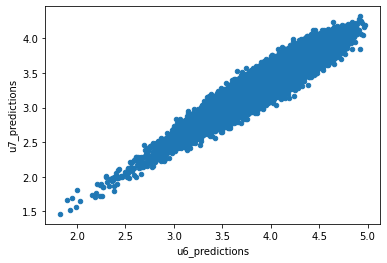

In [23]:
product_index[["u6_predictions", "u7_predictions"]].plot.scatter("u6_predictions", "u7_predictions")
plt.show()

이 상관 관계가 거의 완벽하다는 것을 알 수 있습니다. 기본적으로 item 들의 평균 평점은 사용자 전체에서 우세하며 모든 사람에게 잘 리뷰된 동일한 item 을 추천합니다. 결과적으로 더 많은 임베딩을 추가 할 수 있으며 사용자 간의 차등 선호도를 더 잘 포착 할 수 있기 때문에 이러한 관계는 사라질 것입니다.

그러나 64 차원 임베딩으로는 3번의 epoch만 실행하는 데 7분이 걸렸습니다. Notebook Instance 외부에서 이 작업을 실행하면 생산성이 향상될 수 있습니다.

---

## Train with SageMaker

이제 이 작은 데이터세트에 대해 train 을 마쳤으므로 SageMaker 의 분산, 완전 관리되는 학습 환경에서 train 을 확장할 수 있습니다.

### Wrap Code

SageMaker의 사전 빌드된 MXNet 컨테이너를 사용하려면 위의 코드를 파이썬 스크립트로 래핑해야 합니다. SageMaker의 사전 구축된 컨테이너를 사용하는 데에는 많은 유연성이 있으며 자세한 문서는 [here](https://github.com/aws/sagemaker-python-sdk#mxnet-sagemaker-estimators) 에서 찾을 수 있지만 이 예제에서는 다음과 같이 구성되었습니다.

1. 모든 데이터 준비를 `prepare_train_data` 함수로 래핑 (원하는 대로 이름을 지정할 수도 있습니다)
1. 위의 단어 단위로 클래스와 함수 복사 및 붙여넣기
1. 다음과 같은 기능을 하는 `train` 함수를 정의합니다.
 1. SageMaker 교육 클러스터에서 입력 TSV 데이터셋을 선택하는 새로운 코드를 약간 추가합니다.
 1. 하이퍼파라미터의 딕셔너리를 취합니다 (위에서 전역으로 지정했습니다)
 1. 네트를 만들고 훈련을 실행합니다.


In [25]:
!pygmentize recommender.py

import json
import logging
import os
import time

import mxnet as mx
import numpy as np
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE

os.system("pip install pandas")
import pandas as pd

logging.basicConfig(level=logging.DEBUG)

#########
# Globals
#########

batch_size = 1024


##########
# Training
##########


def train(channel_input_dirs, hyperparameters, hosts, num_gpus, **kwargs):

    # get data
    training_dir = channel_input_dirs["train"]
    train_iter, test_iter, customer_index, product_index = prepare_train_data(training_dir)

    # get hyperparameters
    num_embeddings = hyperparameters.get("num_embeddings", 64)
    opt = hyperparameters.get("opt", "sgd")
    lr = hyperparameters.get("lr", 0.02)
    momentum = hyperparameters.get("momentum", 0.9)
    wd = hyperparameters.get("wd", 0.0)
    epochs = hyperparameters.get("epochs", 5)

    # define net
    ctx = mx.gpu()

    net = MFBlock(
        max_users=customer_index.shape[0],
        max_items=pro

### Move Data

작은 데이터 샘플을 탐색할 때는 데이터를 메모리에 보관하는 것이 좋지만, 더 크고 오래 실행되는 프로세스의 경우 SageMaker Training 을 사용하여 백그라운드에서 실행하는 것이 좋습니다. 이를 위해 SageMaker train 에서 선택할 수 있도록 데이터 세트를 S3로 이동해 보겠습니다. 이는 주기적인 재교육, 더 큰 데이터 세트로 확장 또는 프로덕션 워크로드를 더 큰 하드웨어로 이전하는 것과 같은 사용 사례에 적합합니다.


In [28]:
%%time
boto3.client("s3").copy(
    {
        "Bucket": "amazon-reviews-pds",
        "Key": "tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz",
    },
    bucket,
    prefix + "/train/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz",
)

### Submit

이제 세이지메이커 파이썬 SDK에서 MXNet estimator 를 만들 수 있습니다. 그러기 위해서는 다음 사항을 전달해야 합니다.
1. SageMaker train 클러스터의 인스턴스 유형 및 수입니다. SageMaker의 MXNet 컨테이너는 분산 GPU 트레이닝을 지원하므로 원하는 경우 이를 여러 ml.p2 또는 ml.p3 인스턴스로 쉽게 설정할 수 있습니다.
 - *참고로, 이 경우 recommender.py 스크립트를 일부 변경해야 합니다. 컨텍스트를 key-value 저장소에 올바르게 설정하고 훈련 데이터를 배포할지 여부와 방법을 결정해야 하기 때문입니다.*
1.출력 모델 아티팩트에 대한 S3 경로와 S3 입력 및 출력 경로에 대한 액세스 권한이 있는 역할
1.신경망을 위한 하이퍼파라미터입니다.64 차원 임베딩을 사용하면 권장 사항이 평균과 너무 가깝게 되돌아 갔으므로 로컬 인스턴스 외부에서 훈련 할 때 이것을 몇 배 늘려 보겠습니다.또한 시간이 지남에 따라 정확도가 어떻게 진화하는지 확인하기 위해 시대를 늘릴 것입니다.다른 모든 하이퍼파라미터는 그대로 두겠습니다.

`.fit () `을 사용하면 인스턴스를 스핀업하고, 적절한 패키지와 데이터를 로드하고, `recommender.py`에서 `train` 함수를 실행하고, 모델 아티팩트를 래핑하여 S3에 저장하고, 클러스터를 분해하여 완료하는 SageMaker 교육 작업이 생성됩니다.

In [ ]:
m = MXNet(
    "recommender.py",
    py_version="py3",
    role=role,
    train_instance_count=1,
    train_instance_type="ml.p3.8xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    hyperparameters={
        "num_embeddings": 512,
        "opt": opt,
        "lr": lr,
        "momentum": momentum,
        "wd": wd,
        "epochs": 10,
    },
    framework_version="1.1",
)

m.fit({"train": "s3://{}/{}/train/".format(bucket, prefix)})

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2022-01-11 08:49:14 Starting - Starting the training job...ProfilerReport-1641890954: InProgress
...
2022-01-11 08:50:00 Starting - Preparing the instances for training....

---

## Host

이제 모델을 학습하였으므로 실시간 프로덕션 엔드포인트에 쉽게 배포할 수 있습니다.

In [ ]:
predictor = m.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

이제 엔드포인트가 생겼으니 테스트해 보겠습니다.로컬 모델의 상단 및 하단 ASIN에 대한 사용자 #6 등급을 예측합니다.

*이 작업은 별도의 웹 서비스에서 HTTP POST 요청을 전송하여 수행할 수 있지만, 작업을 쉽게 하기 위해 SageMaker Python SDK에서 `.predict () `메서드를 사용하겠습니다.*


In [ ]:
type(predictor)

In [57]:
test = json.dumps(
        {
            "customer_id": customer_index[customer_index["user"] == 6][
                "customer_id"
            ].values.tolist(),
            "product_id": ["B00KH1O9HW", "B00M5KODWO"],
        }
    )

In [65]:
predictor.predict(json.loads(
    json.dumps(
        {
            "customer_id": customer_index[customer_index["user"] == 6][
                "customer_id"
            ].values.tolist(),
            "product_id": ["B00KH1O9HW", "B00M5KODWO"],
        }
    ))
)

[5.103163719177246, 1.5584197044372559]

*참고로, 일부 예측은 실제로 5보다 크며, 등급이 해당 값으로 제한되는 것을 설명하기 위해 특별한 조치를 취하지 않았기 때문에 예상됩니다.예상 평점으로만 순위를 매길 예정이므로 특정 사용 사례에는 문제가 발생하지 않습니다.*

### Evaluate

먼저 모델이 얼마나 잘 작동하고 있는지 측정하기 위해 naive baseline 을 계산해 보겠습니다. 가장 간단한 estimator 는 모든 사용자 항목 등급이 모든 평점에 대한 평균 평점이라고 가정하는 것입니다.

*각 개별 비디오의 평균을 사용하면 더 나은 결과를 얻을 수 있지만, 이 경우 동일한 결론이 유지되므로 중요하지 않습니다.*

In [66]:
print("Naive MSE:", np.mean((test_df["star_rating"] - np.mean(train_df["star_rating"])) ** 2))

Naive MSE: 1.6493581487802726


이제 테스트 데이터셋에 대한 예측을 계산해 보겠습니다.

*참고로 위의 CloudWatch 출력과 거의 일치하지만 eval_net 함수에서 부분 미니 배치를 건너뛰기 때문에 약간 다를 수 있습니다.*

In [68]:
test_preds = []
for array in np.array_split(test_df[["customer_id", "product_id"]].values, 40):
    test_preds += predictor.predict(
        json.loads(json.dumps({"customer_id": array[:, 0].tolist(), "product_id": array[:, 1].tolist()}))
    )

test_preds = np.array(test_preds)
print("MSE:", np.mean((test_df["star_rating"] - test_preds) ** 2))

MSE: 1.2696960969112074


신경망과 임베딩 모델이 훨씬 더 나은 결과를 생성한다는 것을 알 수 있습니다 (평균 제곱 오차의 경우 약 1.27 대 1.65).

추천 시스템의 경우 주관적인 정확성도 중요합니다. 임의의 사용자가 직관적으로 이해되는지 확인하기 위해 몇 가지 추천 아이템을 살펴보겠습니다.

In [69]:
reduced_df[reduced_df["user"] == 6].sort_values(["star_rating", "item"], ascending=[False, True])

,customer_id,product_id,star_rating,product_title,user,item
55340,50818682,B00DAHSY58,5,"Under The Dome, Season 1",6,5
96053,50818682,B00LI0VA4Q,5,"Extant, Season 1",6,6
39816,50818682,B00L86ZKAK,5,"Under The Dome, Season 2",6,20
182902,50818682,B006IX92XO,5,Rome Season 1,6,27
83341,50818682,B00821OX98,5,Falling Skies Season 1,6,40
...,...,...,...,...,...,...
1060778,50818682,B00TY68T6I,1,The Returned Season 1,6,11493
938194,50818682,B00KQFOLBI,1,Mirage Men,6,12443
957127,50818682,B001JDQXCG,1,The New World (2005),6,13451
900998,50818682,B00IAKN6V2,1,Welcome To The Jungle,6,17000


보시다시피 #6 사용자는 드라마틱 한 TV 시리즈와 공상 과학을 좋아하는 것 같지만 코미디를 싫어합니다.

이제 카탈로그에 있는 모든 일반 동영상에 대한 사용자 #6 등급을 반복하여 예측하여 어떤 동영상을 추천하고 어떤 동영상을 추천하지 않을지 알아보겠습니다.

In [71]:
predictions = []
for array in np.array_split(product_index["product_id"].values, 40):
    predictions += predictor.predict(json.loads(
        json.dumps(
            {
                "customer_id": customer_index[customer_index["user"] == 6][
                    "customer_id"
                ].values.tolist()
                * array.shape[0],
                "product_id": array.tolist(),
            }
        )
    ))

predictions = pd.DataFrame({"product_id": product_index["product_id"], "prediction": predictions})

In [72]:
titles = reduced_df.groupby("product_id")["product_title"].last().reset_index()
predictions_titles = predictions.merge(titles)
predictions_titles.sort_values(["prediction", "product_id"], ascending=[False, True])

,product_id,prediction,product_title
33345,B004N796H4,6.154150,Doc Hollywood
3583,B00Z620OVW,5.988809,"Poldark, Season 1"
15890,B00EMSTBL0,5.968293,"The Incredible Dr. Pol, Season 3"
432,B003ITOL8C,5.901760,Doc Martin Season 2
1576,B00366GELO,5.868101,Foyle's War Season 4
...,...,...,...
2806,B00A7YXU0G,1.930092,Savage Island
3952,B00NESTCC2,1.890782,2035 Forbidden Dimensions
4556,B00DKGWLGM,1.885139,Battle Earth
7531,B00M5KODWO,1.558420,The Becoming: 2015


실제로, 우리의 높은 평가를받은 쇼에는 잘 검토 된 TV 드라마와 공상 과학이 있습니다. 가장 낮은 등급의 쇼에는 코미디가 포함됩니다.

*가중치의 임의 초기화로 인해 후속 실행의 결과가 약간 다를 수 있습니다.*

#7 사용자와의 권장 사항에서 더 이상 완벽한 상관 관계가 없는지 확인하겠습니다.

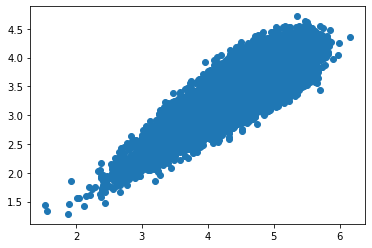

In [73]:
predictions_user7 = []
for array in np.array_split(product_index["product_id"].values, 40):
    predictions_user7 += predictor.predict(json.loads(
        json.dumps(
            {
                "customer_id": customer_index[customer_index["user"] == 7][
                    "customer_id"
                ].values.tolist()
                * array.shape[0],
                "product_id": array.tolist(),
            }
        )
    ))
plt.scatter(predictions["prediction"], np.array(predictions_user7))
plt.show()

---

## Wrap-up

이 예에서는 고객 평점을 예측하는 딥 러닝 모델을 개발했습니다. 이는 다양한 사용 사례에서 추천 시스템의 기초가 될 수 있습니다. 그러나 개선할 수 있는 방법에는 여러 가지가 있습니다. 예를 들어 우리는 다음과 같은 부분은 거의 수행하지 않았습니다.
- 하이퍼파라미터 튜닝
- 과적합에 대한 제어 (early stopping, dropout 등)
- 목표 변수를 이진화하여 결과를 개선할 수 있는지 테스트
- 기타 정보 출처 포함 (비디오 장르, 과거 등급, 검토 시간)
- 사용자 및 아이템 포함에 대한 기준 조정 

모델을 개선하는 것 외에도 다음과 같은 방법으로 엔지니어링을 개선할 수 있습니다.
- 분산 교육을 위한 컨텍스트 및 키 값 저장 설정
- GPU를 완전히 활용할 수 있도록 데이터 수집 (예: 데이터 반복기의 num_workers) 을 미세 조정
- 데이터 세트가 단일 머신 이상으로 확장됨에 따라 전처리가 어떻게 변경되어야 하는지 생각

그 외에도 추천 시스템은 능동적 학습, 강화 학습, 세분화, 앙상블 등의 연구 및 기술의 매우 활발한 영역이며 균형 잡힌 권장 사항을 제공하기 위해 조사해야합니다.

### Clean-up (optional)

endpoint 를 삭제하여 호스팅 비용이 발생하지 않도록 삭제해 보겠습니다.

In [75]:
sagemaker.Session().delete_endpoint(predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
